In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os

In [2]:
data_dir = ("../data/PlantVillage")

BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50



In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [4]:
class_names = dataset.class_names
print(dataset.class_names)



['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


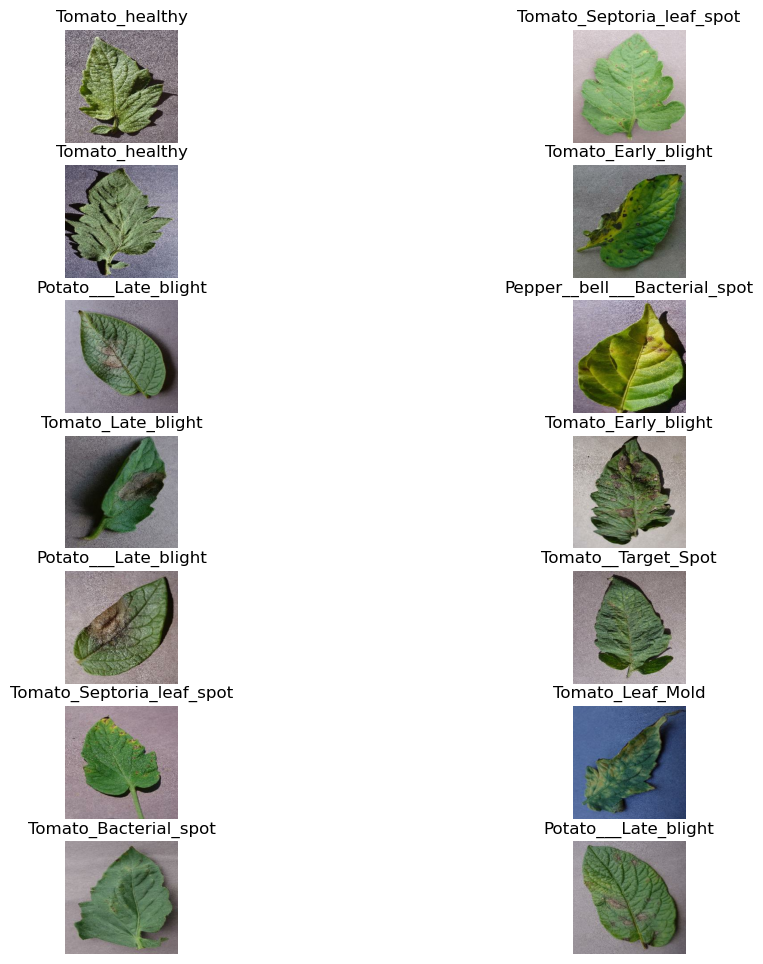

In [5]:
plt.figure(figsize=(12, 12))

for image_batch, labels_batch in dataset.take(1): 
    batch_size = len(image_batch)  
    num_images = min(14, batch_size)
    
    for i in range(num_images):
        ax = plt.subplot(7, 2, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i].numpy()])
        plt.axis("off")  
plt.show()

In [6]:
#Split the dataset
len(dataset)
train_size = 0.7


In [7]:
def split_dataset(dataset, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, seed=42):
    assert round(train_ratio + val_ratio + test_ratio, 5) == 1

    dataset = dataset.shuffle(buffer_size=1000, seed=seed)

    total_size = sum(1 for _ in dataset)  # Convert dataset to list to get length

    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset(dataset)
for image_batch, label_batch in train_ds.take(1):
    print(f"Labels in this batch: {label_batch.numpy()}")

Labels in this batch: [ 4  5  9  0 10  1  8 11  6 10  1  5 12 12  1 10  2  3 12  7 12 12  9 12
 14 13 10  7  9 10 14 11]


In [8]:
#Convert the labels into into int 32
train_ds = train_ds.map(lambda x, y: (x, tf.cast(y, tf.int32)))
val_ds = val_ds.map(lambda x, y: (x, tf.cast(y, tf.int32)))
test_ds = test_ds.map(lambda x, y: (x, tf.cast(y, tf.int32)))

print(f"The length of the dataset is: {len(dataset)}")
print(f"The length of the train dataset is: {len(train_ds)}")
print(f"The length of the validation dataset is: {len(val_ds)}")
print(f"The length of the test dataset is: {len(test_ds)}")

The length of the dataset is: 645
The length of the train dataset is: 451
The length of the validation dataset is: 129
The length of the test dataset is: 65


In [9]:
prepr = keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255),
])

In [10]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),  
    layers.RandomRotation(0.2)       # Rotate images by 20%

])

train_ds = train_ds.map(
lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    prepr,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


C:\Users\ossum\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 15)                    │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 184,527 (720.81 KB)

 Trainable params: 184,527 (720.81 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#Comppile model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [15]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 652s 1s/step - accuracy: 0.2065 - loss: 2.4010 - val_accuracy: 0.4382 - val_loss: 1.7252
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 492s 1s/step - accuracy: 0.4741 - loss: 1.5847 - val_accuracy: 0.6434 - val_loss: 1.0583
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 484s 1s/step - accuracy: 0.6490 - loss: 1.0428 - val_accuracy: 0.6497 - val_loss: 1.0269
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - accuracy: 0.7481 - loss: 0.7479 - val_accuracy: 0.7495 - val_loss: 0.7472
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 493s 1s/step - accuracy: 0.7953 - loss: 0.5909 - val_accuracy: 0.7907 - val_loss: 0.6159
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 491s 1s/step - accuracy: 0.8185 - loss: 0.5192 - val_accuracy: 0.7376 - val_loss: 0.7905
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 470s 1s/step - accuracy: 0.8530 - loss: 0.4253 - val_accuracy: 0.8120 - val_loss: 0.5867
Epoch 8/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - accuracy: 0.8718 - loss: 0.3750 - val_accu

In [16]:
scores = model.evaluate(test_ds)
print(scores)

65/65 ━━━━━━━━━━━━━━━━━━━━ 92s 307ms/step - accuracy: 0.9509 - loss: 0.1536
[0.18169723451137543, 0.9418269395828247]


In [17]:
history

In [18]:
print(history.params)

history.history['loss'][:5]

{'verbose': 1, 'epochs': 50, 'steps': 451}


[2.165295124053955,
 1.4233781099319458,
 0.9660933613777161,
 0.7079238891601562,
 0.5774526000022888]

In [19]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

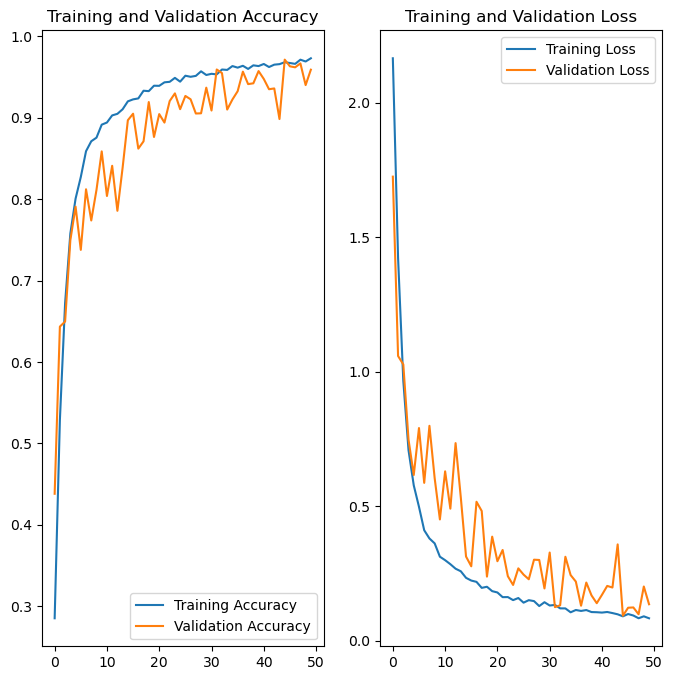

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato_Bacterial_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
predicted label: Tomato_Bacterial_spot


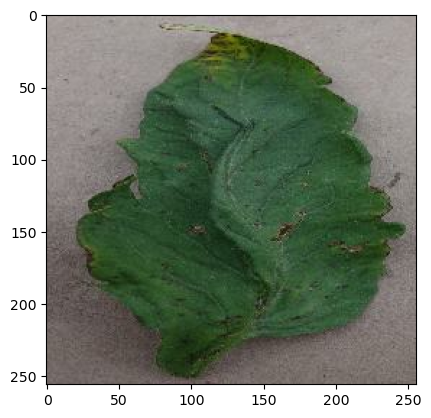

In [22]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [27]:
model.save("plant_disease_model.keras")  
model.save("plant_disease_model.h5")

In [28]:
model.save_weights("model_weights.weights.h5")

In [29]:
import json
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)